# Partikelfilter (1)
Diese Übung baut auf Übung 1 (Ballistik-Beispiel) auf, daher hier zunächst eine mögliche Lösung für Übung 1.

In [1]:
# model preferences
time <- 100    # time [s]
tstep <- 10    # steps / sec [1/s]
times <- time*tstep

# physical constants
g    <- -9.81   # gravitational accelaration [m/(s^2)]
sd.v <- 10      # accuracy of liftoff speed [m/s]
sd.a <- 1       # accuracy of elevation angle in [deg]
turb.x <- 10       # acceleration by turbulences [m/(s^2)]
turb.y <- 10       # acceleration by turbulences [m/(s^2)]
cw   <- 0.0001 # aerobraking factor
sd.o <- 10000     # observation accuracy [m]

# game preferences
xmax <- 21000
epsilon <- 300

# plot preferences
ymin <- -100

deg2rad <- function(x) x / 180 * pi

init <- function(ang = 45, v0 = 500, location = 0) {
    v <- v0 + rnorm(1, sd=sd.v)
    a <- deg2rad(rnorm(1, mean=ang, sd=sd.a))
    c(location, 0, v * cos(a), v * sin(a))
}

trans <- function(s) {
    dt <- 1/tstep
    eps.x <- rnorm(1, mean=0, sd=turb.x)
    eps.y <- rnorm(1, mean=0, sd=turb.y)
    acc.x <- -sign(s[3]) * cw * s[3]^2 + eps.x
    acc.y <- g - sign(s[4]) * cw * s[4]^2 + eps.y
    s.x <- s[1] + s[3] * dt + 0.5 * acc.x * dt * dt
    s.y <- s[2] + s[4] * dt + 0.5 * acc.y * dt * dt
    v.x <- s[3] + acc.x * dt
    v.y <- s[4] + acc.y * dt
    c(s.x, s.y, v.x, v.y)
}

shoot <- function(angle, velocity, location) {
    target <- array(0, dim=c(times,4))
    target[1,] <- init(angle, velocity, location)
    for (t in 2:times) {
        target[t,] <- trans(target[t-1,])
        if (target[t,2] < 0) {
            target <- target[1:(t-1),]
            break
        }
    }
    
    target
}

plotshot <- function(target=array(0, dim=c(1,4)), playerLocations=NULL, title="Target", new.plot=TRUE) {
    if (new.plot) {
        plot(NA, ylim=c(ymin,12000), xlim=c(0, xmax), ylab="Height [km]", xlab="Distance [km]", axes=FALSE)
    }
    lines(target[,1], target[,2], col="red", lwd=2)
    axis(2, labels=c("0","2.5","5","7.5","10"), at=c(0,2500,5000,7500,10000))
    axis(1, labels=c("0","5","10","15","20"), at=c(0,5000,10000,15000,20000))
    
    # plot the y=0 line which represents the "ground"
    abline(h=0, col="lightgray", lwd=2)
    
    # tanks
    for (player in seq_along(playerLocations)) {
        points(playerLocations[player], 0, pch=12, cex=1.4, col="brown")
        text(playerLocations[player] + 200, 100, paste0("Player ", player), adj=c(0,0))
    }

    invisible(NULL)
}

1. Im Skript wird ein Observationsmodell, basierend auf Winkel- und Distanzmessungen einer fiktiven Radarstation, beschrieben. Implementieren Sie eine Funktion `robserve(s)`, die gegeben die Position des Projektils zu einem Zeitpunkt eine mögliche Beobachtung sampled. Ergänzen Sie Ihre Plot-Funktion um eine entsprechende Darstellung der Beobachtung alle 10 Zeitschritte.
2. In einem Partikelfilter wird die a-posteriori Wahrscheinlichkeitsdichte durch die Verteilung von Samples im Zustandsraum repräsentiert. Schreiben Sie dazu eine Funktion `makesamples(n, angle, velocity, location)`, welche $n$ zufällige Trajektorien sampled. Ergänzen Sie Ihren Plot um die Darstellung der Sampletrajektorien.
3. Das Beobachtungsmodell $p(y | s)$ gibt die Wahrscheinlichkeitsdichte an, mit der eine Beobachtung von einem Zustand erzeugt wird. Implementieren Sie eine Funktion `observe(s, obs)`, die gegeben einen Zustand $s$ und einer Beobachtung obs die *Wahrscheinlichkeitsdichte* dieser Beobachtung im gegebenen Zustand berechnet (im Gegensatz zur Funktion `robserve(s)`, die eine Beobachtung *sampled*. 

Der Plot kann beispielsweise so aussehen:
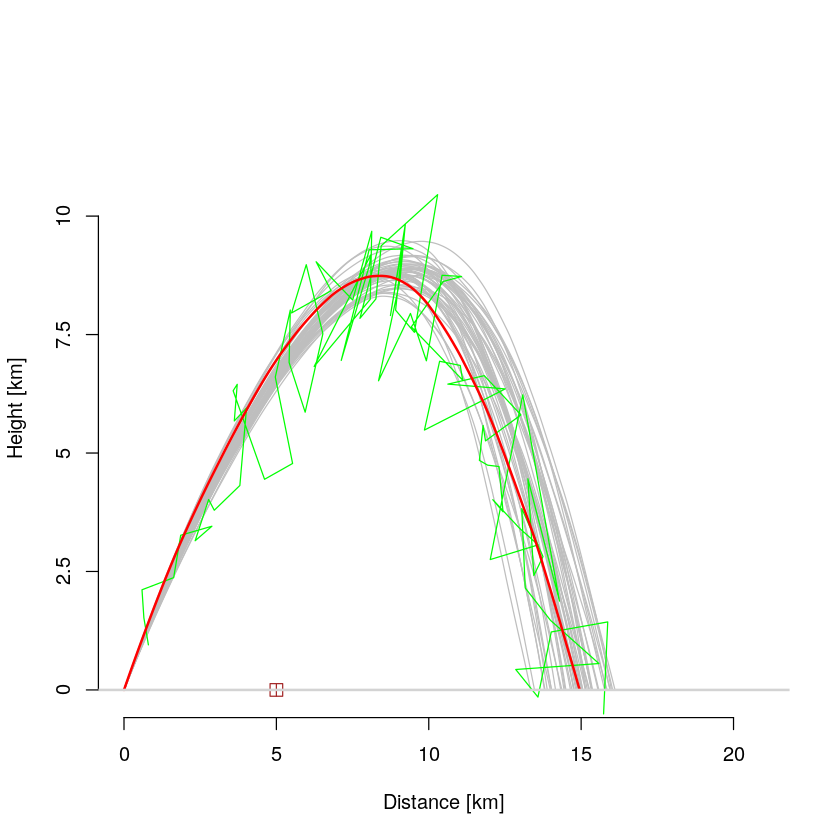

In [2]:
radar.x <- 5000
radar.y <- 0
radar <- c(radar.x, radar.y)
radar.sd.rad <- 0.1
radar.sd.ang <- 5

observe <- function(s, obs) {
    #strategy: compute the true angle and distance from s
    #and the observed angle and distance from obs
    #then compute the density of a normal with mean=truth
  
    o.dx <- obs[1] - radar.x
    o.dy <- obs[2] - radar.y
    obsrad <- sqrt(o.dx^2 + o.dy^2)
    obsang <- atan2(o.dy, o.dx) / pi * 180
    if (obsang < 0)
        # ensure the range is [0, 360), not (-180, 180]
        obsang <- 360 + obsang
    
    s.dx <- s[1] - radar.x
    s.dy <- s[2] - radar.y
    rad <- sqrt(s.dx^2 + s.dy^2)
    ang <- atan2(s.dy, s.dx) / pi * 180
    if (ang < 0)
        # ensure the range is [0, 360), not (-180, 180]
        ang <- 360 + ang
    
    # angles are now in range [0, 360)
    # that means, e.g., 1° and 359° (= -1°) are considered far apart
    # if both angles are < 90 / > 270 (i.e. at the right side of the unit circle),
    # then make large angles negative (e.g. 359 → -1)
    if ((obsang < 90 || obsang > 270) && (ang < 90 || ang > 270)) {
        mn <- function(a) if (a > 270) a - 360 else a
        obsang <- mn(obsang)
        ang <- mn(ang)
    }
    
    dnorm(obsrad, mean=rad, sd=rad * radar.sd.rad) * dnorm(obsang, mean=ang, sd=radar.sd.ang)
}

robserve <- function(s) {
    s.dx <- s[1] - radar.x
    s.dy <- s[2] - radar.y
    rad <- sqrt(s.dx^2 + s.dy^2)
    ang <- atan2(s.dy, s.dx) / pi * 180
    obsrad <- rnorm(1, mean=rad, sd=rad * radar.sd.rad)
    obsang <- rnorm(1, mean=ang, sd=radar.sd.ang) / 180 * pi
    #we output not the angle and distance, but x-y coordinates
    c(obsrad * cos(obsang) + radar.x,
      obsrad * sin(obsang) + radar.y)
}

makesamples <- function(n=50, angle, velocity, location) {
    replicate(n, shoot(angle, velocity, location))
}

plotshot2 <- function(target=array(0, dim=c(1, 4)), observation=NULL, samples=NULL, ostep=10, title="Target") {
    plot(NA, ylim=c(ymin,12000), xlim=c(0, xmax), ylab="Height [km]", xlab="Distance [km]", axes=FALSE)
    
    # samples
    if (!is.null(samples)) {
        n <- length(samples)
        for(i in 1:n)
            lines(samples[[i]][,1],samples[[i]][,2],col="gray")
    }
    
    # observations
    if (!is.null(observation)) { #if not empty run
        osteps <- seq(from=ostep, to=nrow(target), by=ostep)
        lines(observation[1,osteps], observation[2,osteps], col="green")
    }
  
    #position of radar station
    points(radar.x,radar.y,pch=12, cex=1.4, col="brown")

    plotshot(target, NULL, title, new.plot=FALSE)
    
    invisible(NULL)
}

main2 <- function(){
  #simply plot multiple samples
  ss <- makesamples(50,60,800,0)
  #observe a single trajectory
  observation <- apply(ss[[1]],1,function(sr) robserve(sr))
  #plot this
  plotshot2(ss[[1]],samples=ss,observation=observation)
}

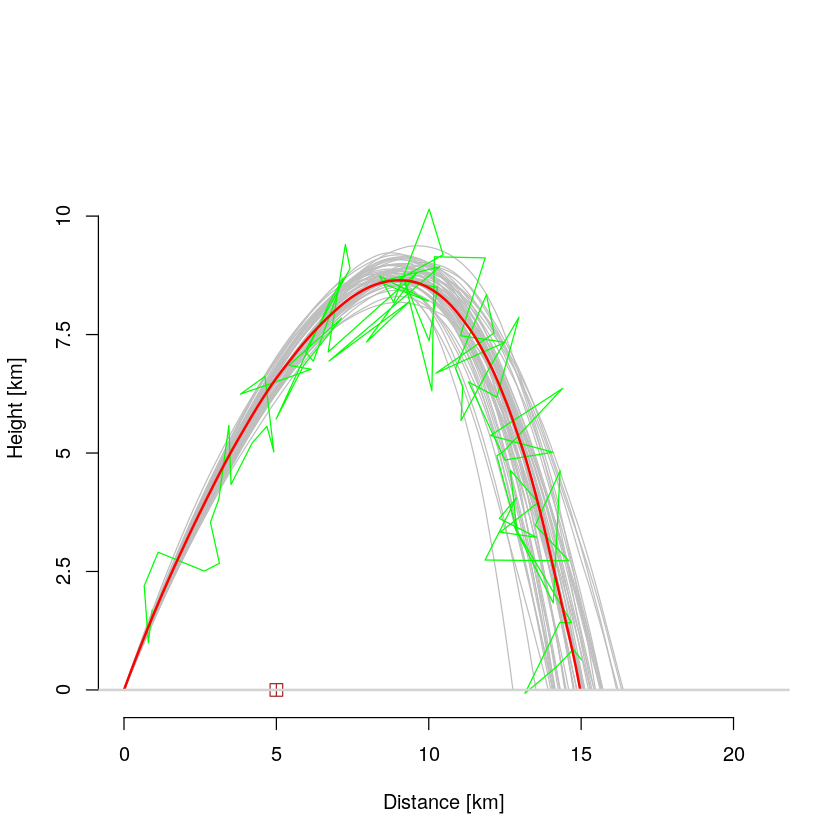

In [3]:
main2()